# Clean label poisioning with feature collision

We optimize base training images so their deep features (the ones of used byy ResNet18) match those of a target image.

The poisoned samples retain their true labels.

The goal is for the model to associate the target image with the poison class, causing it to misclassify at test time.

Note: As we are using CIFAR10 dataset for this task, when we make base image to be like a target image, we just have blurry images as poisions. That is because the images at CIFAR10 dataset are 32x32 and of a bad quality.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset


In [2]:
# Setting deivce to cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Loading CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


In [4]:
# Extracting features to collide them.
# We are using ResNet18 classifier for feature extraction

feature_extractor = resnet18(pretrained=True).to(device)
feature_extractor.fc = nn.Identity()
feature_extractor.eval()

def get_features(img):
    img = img.to(device)
    return feature_extractor(img)

# Choosing dog as a target image
target_class = 5 # Dog
target_index = 12
target_img, _ = testset[target_index]
target_img = target_img.unsqueeze(0).to(device)
target_feat = feature_extractor(target_img).detach()

# Poison class to attack
poison_label = 4   # deer
num_poison = 30

# Pick base images
base_img_indices = [i for i, (_, y) in enumerate(trainset) if y == poison_label][:num_poison]
base_imgs = [trainset[i][0].unsqueeze(0).to(device) for i in base_img_indices]
base_labels = [poison_label for _ in base_img_indices]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


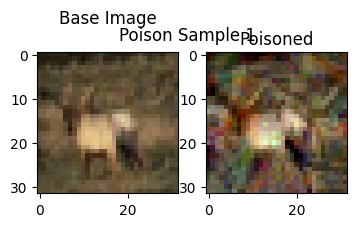

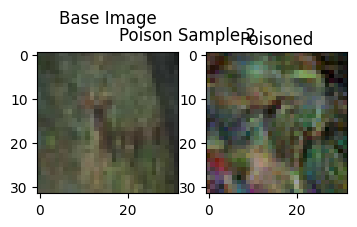

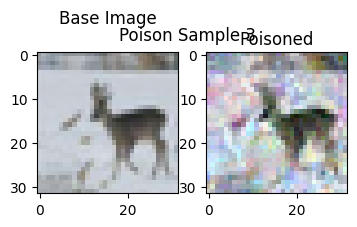

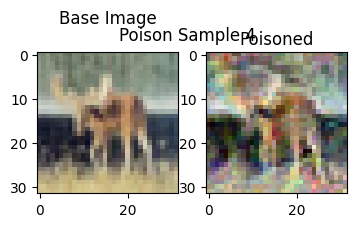

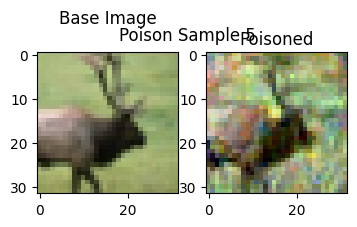

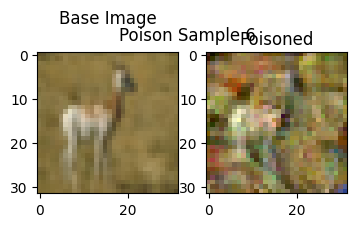

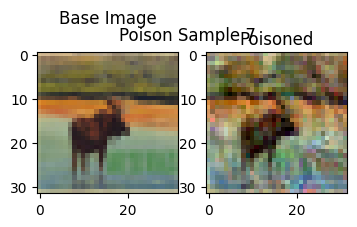

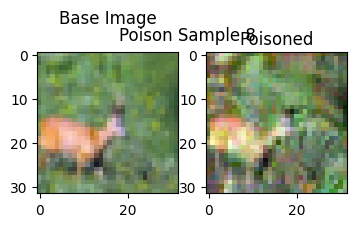

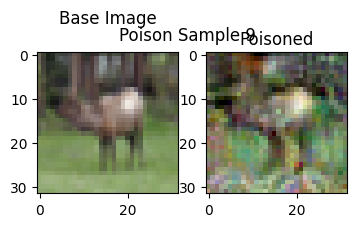

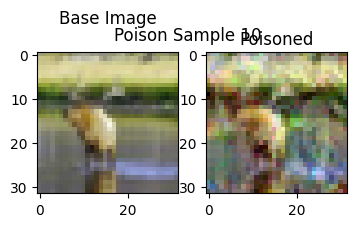

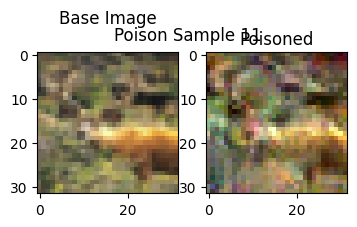

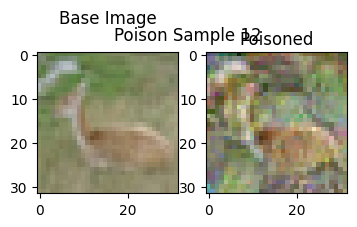

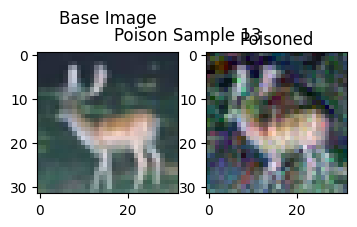

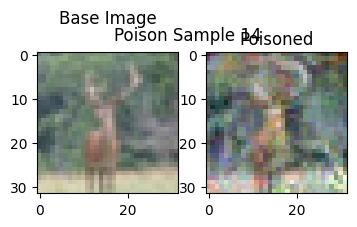

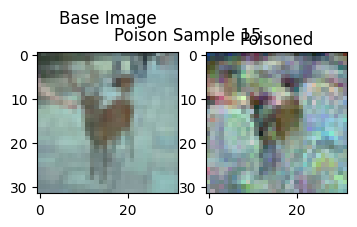

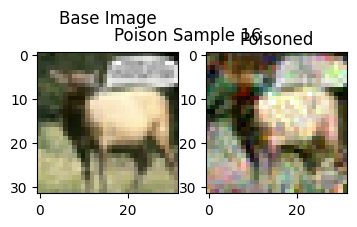

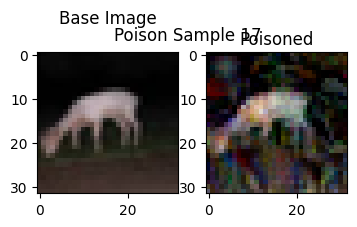

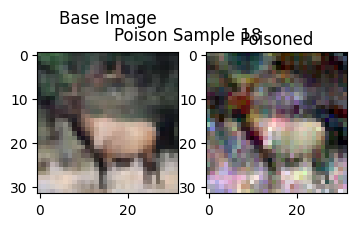

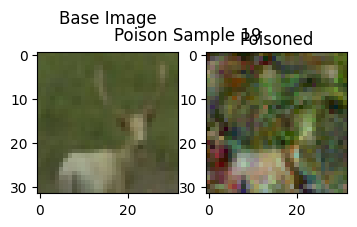

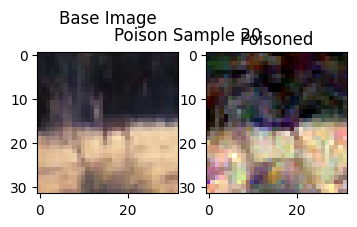

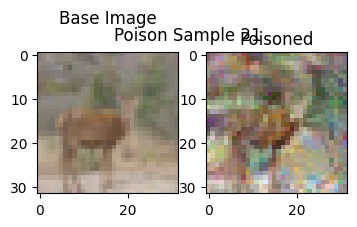

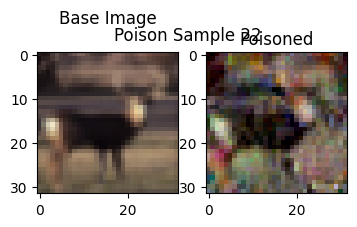

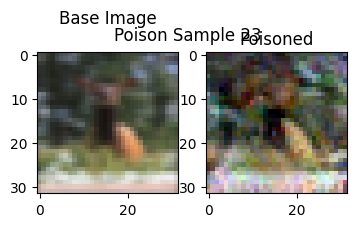

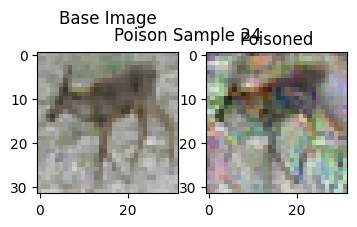

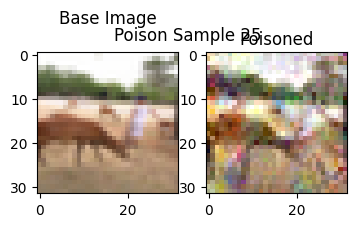

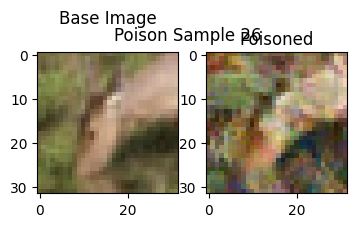

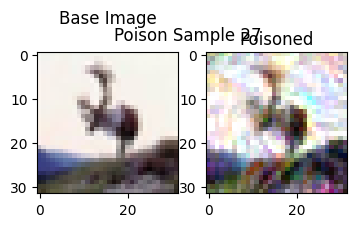

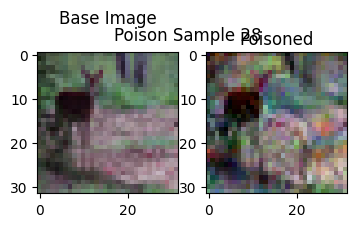

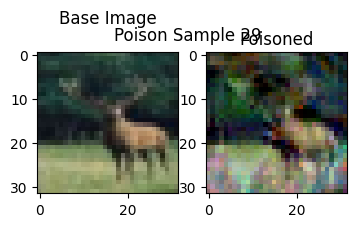

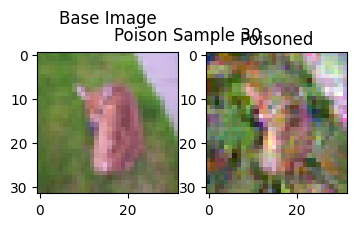

In [5]:
# Poisoning the dataset
poisoned_imgs = []

for i, base_img in enumerate(base_imgs):
    poison_img = base_img.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([poison_img], lr=0.01)

    for step in range(300):
        optimizer.zero_grad()
        feat = get_features(poison_img)
        loss = F.mse_loss(feat, target_feat)
        loss.backward()
        optimizer.step()
        poison_img.data.clamp_(0, 1)

    poisoned_imgs.append(poison_img.detach().cpu())

    #compariing the clean and poisioned images
    fig, axs = plt.subplots(1, 2, figsize=(4, 2))
    axs[0].imshow(base_img.squeeze().permute(1, 2, 0).cpu())
    axs[0].set_title("Base Image\n")
    axs[1].imshow(poison_img.detach().squeeze().permute(1, 2, 0).cpu())
    axs[1].set_title("Poisoned")
    plt.suptitle(f"Poison Sample {i+1}")
    plt.show()


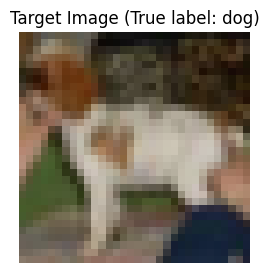

In [6]:
# CIFAR-10 class labels
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

# The target image we will classify
plt.figure(figsize=(3, 3))
plt.imshow(target_img.squeeze().permute(1, 2, 0).cpu())
plt.title(f"Target Image (True label: {classes[target_class]})", fontsize=12)
plt.axis("off")
plt.show()


In [7]:
class PoisonedCIFAR10(Dataset):
    def __init__(self, original_dataset, poisoned_imgs, poisoned_indices):
        self.dataset = original_dataset
        self.poisoned_imgs = poisoned_imgs
        self.poisoned_indices = poisoned_indices
        self.poison_label = original_dataset[poisoned_indices[0]][1]

    def __getitem__(self, idx):
        if idx in self.poisoned_indices:
            return self.poisoned_imgs[self.poisoned_indices.index(idx)].squeeze(), self.poison_label
        return self.dataset[idx]

    def __len__(self):
        return len(self.dataset)

poisoned_dataset = PoisonedCIFAR10(trainset, poisoned_imgs, base_img_indices)
poisoned_loader = torch.utils.data.DataLoader(poisoned_dataset, batch_size=128, shuffle=True)


In [8]:
model = resnet18(pretrained=False, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    running_loss = 0.0
    for images, labels in poisoned_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}: Loss = {running_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1: Loss = 539.0489
Epoch 2: Loss = 386.2901
Epoch 3: Loss = 318.4110
Epoch 4: Loss = 269.0966
Epoch 5: Loss = 230.8289
Epoch 6: Loss = 193.5656
Epoch 7: Loss = 163.2163
Epoch 8: Loss = 133.4886
Epoch 9: Loss = 111.3407
Epoch 10: Loss = 90.7378


Target Image Prediction: 4 — True: 5


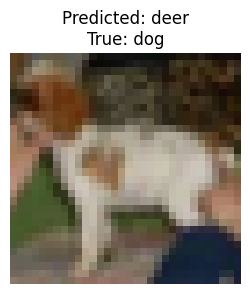

In [9]:
#Testing how our poisionging works

model.eval()
with torch.no_grad():
    out = model(target_img)
    pred = out.argmax(1).item()
    print(f"Target Image Prediction: {pred} — True: {target_class}")


plt.figure(figsize=(3, 3))
plt.imshow(target_img.squeeze().permute(1, 2, 0).cpu())
plt.title(f"Predicted: {classes[pred]}\nTrue: {classes[target_class]}", fontsize=12)
plt.axis("off")
plt.show()

